In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
# # functions (the teacher wrote for you to use later)
# def rot2d(x, y, theta, unit='degree'):
#     """ rotate data points defined by `x` and `y` by `theta` degree
#     """
#     a = np.vstack([x,y]).T
#     if unit == 'degree':
#         theta = theta*np.pi/180 # convert to radian

#     R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
#     ar = a.dot(R.T)
#     return ar[:,0], ar[:,1]

# def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
#                title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
#                vmin=None, **cbar_kwargs):
#     """customized scatter plot -- yesterday's progress
#     """
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
  
#     fig, ax = plt.subplots(figsize=(10,8))
#     if gexp is not None:
#         vmax = np.percentile(gexp, vmax_p)
#         if unit_norm:
#             rgexp = gexp/vmax
#             g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
#             fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
#             title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
#         else:
#             g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
#             fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
#     else:
#         g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
#     if axis_off:
#         ax.axis('off')
#     ax.set_title(title)
#     ax.set_aspect('equal')
  
#     if output:
#         powerplots.savefig_autodate(fig, output)
        
#     return 

# def st_scatter_ax(ax, x, y, gexp=None, vmax_p=98, unit_norm=False, 
#                title='', s=1, cbar_label='', cmap='rocket_r', axis_off=True, 
#                vmin=None, **cbar_kwargs):
#     """customized scatter plot -- yesterday's progress
#     """
#     from mpl_toolkits.axes_grid1 import make_axes_locatable
  
#     if gexp is not None:
#         vmax = np.percentile(gexp, vmax_p)
#         if unit_norm:
#             rgexp = gexp/vmax
#             g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
#             fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
#             title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
#         else:
#             g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
#             fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
#     else:
#         g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
#     if axis_off:
#         ax.axis('off')
#     ax.set_title(title)
#     ax.set_aspect('equal')
  
#     return 

# # visualize clusters
# def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
#     """this assumes `clsts` is a integer that starts from 0
#     """
#     from matplotlib import colors
  
#     unq_clsts, inv = np.unique(clsts, return_inverse=True)
#     n_unq = len(unq_clsts)
#     # colors = np.array(sns.color_palette('husl', n_unq))
#     # c_vec = colors[inv]
  
#     cmap = plt.cm.jet
#     norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
#     fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
#     ax = axs[0]
#     g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
#     ax.set_title('XY (spatial distribution)')
#     ax.set_aspect('equal')
#     if axis_off:
#         ax.axis('off')
    
#     ax = axs[1]
#     ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
#     ax.set_title('UMAP (molecular similarity)')
#     ax.set_aspect('equal')
#     if axis_off:
#         ax.axis('off')
  
#     fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
#     return fig, axs

In [4]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [5]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240228"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [6]:
from merfish_datasets import merfish_datasets
import json

directories = merfish_datasets
print(merfish_datasets)

name = 'P28NR_ant'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
fout = full_dirc+'detected_transcripts_v1l23fovs.csv'

f1 = full_dirc+'detected_transcripts.csv'
df = pd.read_csv(f1, nrows=1000)

f2 = full_dirc+'cell_metadata.csv'
df2 = pd.read_csv(f2, index_col=0)
df2['cell_id'] = df2.index


{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [7]:
f_main = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240318.h5ad'
f_meta = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240318_xy_operations.json'

adata = ad.read(f_main)
bound_l, bound_r, bound_d = 3000, 4200, 400
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]
adatasub
# df

    

View of AnnData object with n_obs × n_vars = 1535 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'depth', 'width'
    obsm: 'blanks', 'pca'
    layers: 'norm'

In [8]:
with open(f_meta, 'r') as fh:
    xy_operations = json.load(fh)
    rotation_angle = xy_operations['rotation']
    ref_line = np.array(xy_operations['ref_line'])
    
print(rotation_angle)
print(ref_line.shape)

90
(100, 2)


In [10]:
# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((18,),
 array([2262, 2263, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329,
        2377, 2378, 2379, 2380, 2381, 2382, 2383]))

In [11]:

chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)
           

0 2.2066867351531982
1 4.228358745574951
2 6.303379774093628
3 8.599093437194824
4 10.454532384872437
5 12.104806900024414
6 14.073911666870117
7 16.471592903137207
8 18.49003505706787
9 20.65388774871826
10 22.509674549102783
11 24.353676319122314
12 26.21492075920105
13 28.056571006774902
14 29.76957893371582
15 31.804187297821045
16 34.25773811340332
17 36.49895215034485
18 38.52658176422119
19 40.66069674491882
20 42.62394857406616
21 44.40558457374573
22 46.86370062828064
23 48.810665130615234
24 50.574791431427
25 52.78397607803345
26 54.90935230255127
27 56.98647117614746
28 58.949198961257935
29 60.57731533050537
30 62.417731285095215
31 63.787209033966064
32 65.58467292785645
33 67.0654067993164
34 68.85080909729004
35 70.56825280189514
36 72.31521773338318
37 73.8288459777832
38 75.63594651222229
39 77.14825582504272
40 79.12800312042236
41 80.63560557365417
42 82.4628415107727
43 84.04416799545288
44 86.32953095436096
45 87.7945339679718
46 90.04216051101685
47 91.7494316101

In [12]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
84789949,18,0,12088.416,7427.0527,0.0,512.75920,263.59180,2262,Cdh4,ENSMUST00000000314,2595481503174100051
84789950,19,0,12150.295,7427.9390,0.0,1085.70690,271.79623,2262,Cdh4,ENSMUST00000000314,2595481503174100082
84789951,24,0,12223.335,7431.5320,0.0,1762.00820,305.06714,2262,Cdh4,ENSMUST00000000314,-1
84789952,39,0,12043.761,7450.2640,0.0,99.28781,478.51013,2262,Cdh4,ENSMUST00000000314,-1
84789953,45,0,12084.694,7463.9487,0.0,478.30072,605.22156,2262,Cdh4,ENSMUST00000000314,2595481503229100018
...,...,...,...,...,...,...,...,...,...,...,...
93804543,132,531,12839.422,6446.9146,6.0,119.35749,575.00000,2383,Blank-32,Blank-32,-1
93804544,197,531,12851.047,6504.1543,6.0,227.00000,1105.00000,2383,Blank-32,Blank-32,2595481502795100023
93804545,204,531,12873.354,6510.2207,6.0,433.53986,1161.16980,2383,Blank-32,Blank-32,2595481502795100025
93804546,98,532,12843.875,6500.3105,6.0,160.59010,1069.40990,2383,Blank-33,Blank-33,2595481502795100023


In [13]:
df_v1l23.to_csv(fout, header=True, index=False)
# !head $fout

In [14]:
a = df_v1l23[df_v1l23['gene']=='Cdh13']
b = df_v1l23[df_v1l23['gene']=='Sorcs3']
c = df_v1l23[df_v1l23['gene']=='Chrm2']
print(a.shape, b.shape, c.shape)

(905, 11) (2588, 11) (1264, 11)


<Axes: xlabel='global_x', ylabel='global_y'>

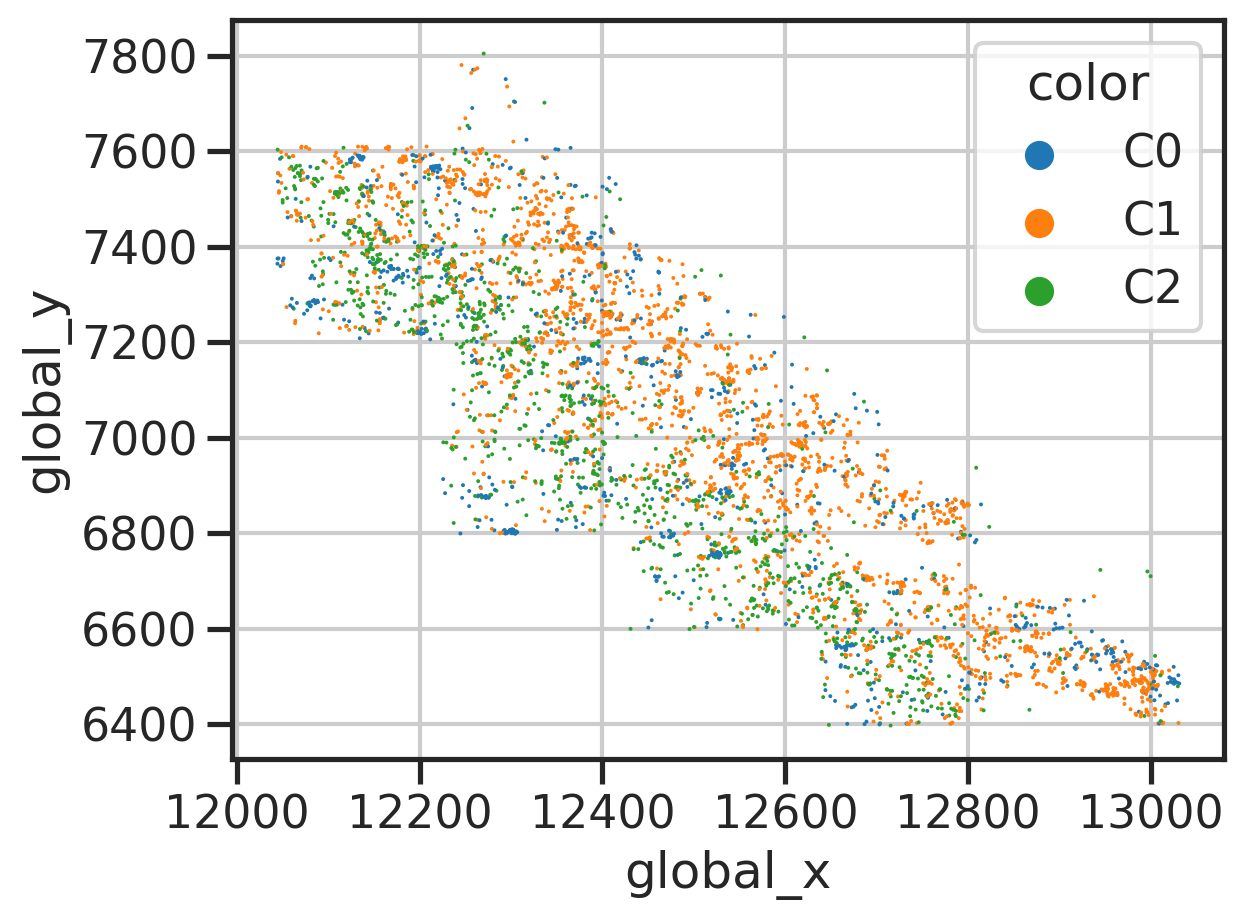

In [15]:
abc = pd.concat([a,b,c])
abc['color'] = ['C0']*len(a)+['C1']*len(b)+['C2']*len(c)
sns.scatterplot(data=abc.sample(frac=1, replace=False), x='global_x', y='global_y', hue='color', hue_order=['C0', 'C1', 'C2'], s=2, edgecolor='none')

# get rotation and ref line
# calculate the width and the depth as cells

In [16]:
# depth ref
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [17]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)].copy()

x = abc['global_x'].values
y = abc['global_y'].values
xr, yr = rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 
print(len(abc))

abc['x'] = xr
abc['y'] = yr
abc['depth'] = ref_line_obj.ndist_to_qps(XY)
abc['width'] = ref_line_obj.tdist_to_qps(XY)


cond_spots = np.all([
    abc['width'] > bound_l, 
    abc['width'] < bound_r, 
    abc['depth'] < bound_d, 
], axis=0)

abc = abc[cond_spots]
print(len(abc))
abc.value_counts('gene').reindex(query_genes) 

4757
3073


gene
Cdh13      493
Sorcs3    1881
Chrm2      699
dtype: int64

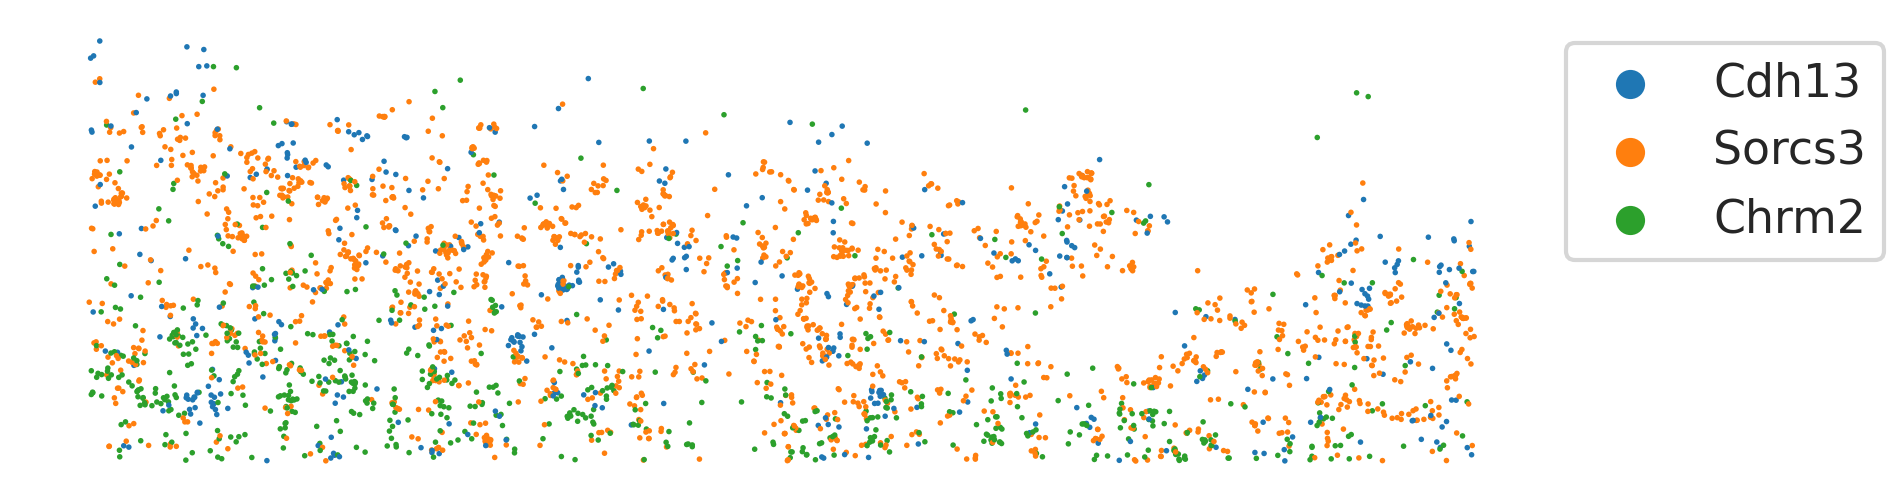

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()